In [1]:
import numpy as np
import os
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence, Categorical
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot  as plt
import matplotlib.animation as animation
%matplotlib inline
from tqdm import tqdm
import tensorflow as tf

**Helper function**

In [72]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5,normalize = True)
    plt.axis('off')
    plt.imshow(np.transpose(image_grid, (1,2,0)))
    # plt.imshow(image_grid.permute(1, 2, 0).squeeze() * 255)

**Residual Block**

In [95]:
class ResBlock(nn.Module):
    def __init__(self,im_chan,hidden_chan):
        super(ResBlock,self).__init__()
        self.res = nn.Sequential(
            nn.Conv2d(im_chan,hidden_chan,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(hidden_chan),
            nn.ReLU(True),
            nn.Conv2d(hidden_chan,im_chan,kernel_size=1,stride=1,padding=0),
            nn.BatchNorm2d(im_chan),
            nn.ReLU(True),
        )
    
    def forward(self,x):
        return x + self.res(x)

class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
      super(ResidualStack,self).__init__()
      self._num_residual_layers = num_residual_layers
      self._layers = nn.ModuleList([ResBlock(in_channels,num_hiddens, num_residual_hiddens)
                             for _ in range(num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

**Vectorize Quantizer**

In [59]:
class VQ(nn.Module):
    def __init__(self,num_embeddings,embedding_size,commitment_cost=0.25,training=True):
        super(VQ,self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_size = embedding_size
        self.commitment_cost = commitment_cost
        self.embedding = nn.Embedding(num_embeddings,embedding_size)
        self.embedding.weight.data.uniform_(-1. / num_embeddings, 1. / num_embeddings)
        self.training = training

    def forward(self, x):
        #convert BCHW to BHWC
        x = x.permute(0, 2, 3, 1).contiguous()
        x_flat = x.view(-1, self.embedding_size) #flatten layer
        w = self.embedding.weight

        #calculate distance
        distances = torch.sum(x_flat ** 2, dim=1, keepdim=True) + torch.sum(w ** 2, dim=1) - 2 * (x_flat @ w.T)

        #encoding
        indices_flat = torch.argmin(distances,dim=1,keepdim=True)
        quantized_flat = self.emb(indices_flat)
        quantized = quantized_flat.view(x.shape)
        indices = indices_flat.view(*x.shape[:3]).unsqueeze(dim=1)

        if self.training:
           e_latent_loss = F.mse_loss(quantized.detach(), x)
           q_latent_loss = F.mse_loss(quantized, x.detach())
           loss = q_latent_loss + self.commitment_cost * e_latent_loss

           quantized = x + (quantized - x).detach()
        else:
           loss = 0.
        
        quantized = quantized.permute(0, 3, 1, 2).contiguous()  # from 
        return quantized, indices, loss
    
    def emb(self,indices):
        quantized = self.embedding(indices)
        return quantized

**Encoder**

In [60]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        self.relu = nn.ReLU(True)
    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = self.relu(x)

        x = self._conv_2(x)
        x = self.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

**Decoder**

In [61]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):  
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=1, #modify here to change output_channels
                                                kernel_size=4, 
                                                stride=2, padding=1)

        self.relu = nn.ReLU(True)

    def forward(self,inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = self.relu(x)
        
        return self._conv_trans_2(x)

**VQ-VAEs**

In [99]:
class VQVAEs(nn.Module):
    def __init__(self, in_channels, num_embeddings, embedding_size=32, res_hidden_channels=32, commitment_cost=0.25):
        super().__init__()
        self.in_channels = in_channels
        self.num_embeddings = num_embeddings
        self.embedding_size = embedding_size
        
        h = embedding_size
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, h, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(h),
            nn.ReLU(inplace=True),
            nn.Conv2d(h, h, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(h),
            ResBlock(h, res_hidden_channels),
            ResBlock(h, res_hidden_channels),
            ResBlock(h, res_hidden_channels)
        )
        
        #self.encoder = Encoder(in_channels, h, 3, res_hidden_channels)
        self.vq = VQ(num_embeddings, embedding_size, commitment_cost)
        #self.decoder = Decoder(in_channels, h, 3, res_hidden_channels)
        self.decoder = nn.Sequential(
            ResBlock(h, res_hidden_channels),
            ResBlock(h, res_hidden_channels),
            ResBlock(h, res_hidden_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(h, h, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(h),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(h, in_channels, kernel_size=4, stride=2, padding=1)
        )
    # def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
    #              num_embeddings, embedding_dim=32, commitment_cost = 0.25):
    #     super(VQVAEs, self).__init__()
        
        # self._encoder = Encoder(1, num_hiddens,
        #                         num_residual_layers, 
        #                         num_residual_hiddens)
        # self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
        #                               out_channels=embedding_dim,
        #                               kernel_size=1, 
        #                               stride=1)
        
        # self._vq_vae = VQ(num_embeddings, embedding_dim,
        #                                    commitment_cost)
        # self._decoder = Decoder(embedding_dim,
        #                         num_hiddens, 
        #                         num_residual_layers, 
        #                         num_residual_hiddens)


    def forward(self, x):
        z = self.encoder(x)
        quantized, indices, loss = self.vq(z)
        x_recon = self.decoder(quantized)

        return x_recon, quantized, indices, loss


**Setup component**

In [73]:
trainset = datasets.MNIST('train_data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
testset = datasets.MNIST('test_data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)

In [100]:
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 32

commitment_cost = 0.25

learning_rate = 2e-3
device = 'cuda'

In [101]:
# model = VQVAEs(num_hiddens, num_residual_layers, num_residual_hiddens,
#               num_embeddings, embedding_dim, 
#               commitment_cost).to(device)
vq_vae = VQVAEs(1, 128, num_embeddings).to(device)

In [102]:
optimizer = optim.Adam(vq_vae.parameters(), lr=learning_rate)

**Training**

Epoch 0


100%|██████████| 600/600 [00:14<00:00, 42.06it/s]


recon_error:  0.03984924746056398
quantization_error:  1.9631224689384301


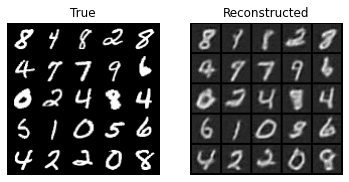

Epoch 1


100%|██████████| 600/600 [00:14<00:00, 42.15it/s]


recon_error:  0.01984123846826454
quantization_error:  0.2521664630373319


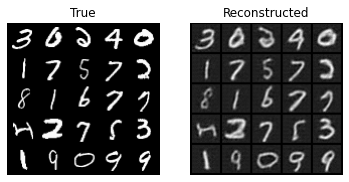

Epoch 2


100%|██████████| 600/600 [00:17<00:00, 34.06it/s]


recon_error:  0.015864613329370815
quantization_error:  0.13061866431186597


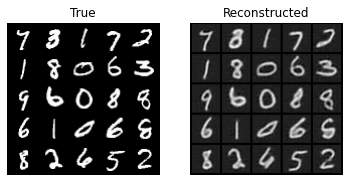

Epoch 3


 47%|████▋     | 282/600 [00:08<00:09, 34.39it/s]


KeyboardInterrupt: ignored

In [103]:
import time
import numpy as np

vq_vae.train()
# loss_recon = []
# loss_quan = []
for epoch in range(200):
    print(f"Epoch {epoch}")
    time.sleep(0.5)
    loss_recon = []
    loss_quan = []
    for data,_ in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        data_recon, quantized, indices, vq_loss = vq_vae(data)
        recon_error = F.mse_loss(data_recon, data)
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()
        
        loss_recon.append(recon_error.item())
        loss_quan.append(vq_loss.item())
    plt.subplot(1,2,1)
    print('recon_error: ',np.mean(loss_recon))
    print('quantization_error: ',np.mean(loss_quan))
    show_tensor_images(data)
    plt.title("True")
    plt.subplot(1,2,2)
    show_tensor_images(data_recon)
    plt.title("Reconstructed")
    plt.show()

**Ref**

In [ ]:
"https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb"